In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
df=pd.read_csv('amazon.csv')
df.info()
df=df.iloc[:,1:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   int64  
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(2), int64(7), object(3)
memory usage: 460.9+ KB


In [3]:
df.head(10)

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.000000
1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.000000
2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.000000
3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.000000
4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.000000
5,2Cents!,5,It's mini storage. It doesn't do anything els...,29-04-2013,588,0,0,0,0,0.0,0.000000
6,2K1Toaster,5,I have it in my phone and it never skips a bea...,19-10-2013,415,0,0,0,0,0.0,0.000000
7,"35-year Technology Consumer ""8-tracks to 802.11""",5,It's hard to believe how affordable digital ha...,07-10-2014,62,0,0,0,0,0.0,0.000000
8,4evryoung,5,Works in a HTC Rezound. Was running short of ...,24-03-2014,259,1,0,1,1,1.0,0.206549
9,53rdcard,5,"in my galaxy s4, super fast card, and am total...",10-11-2013,393,0,0,0,0,0.0,0.000000


In [4]:
df.isnull().any(axis=0)
df.dropna(inplace=True)

In [5]:
df.isnull().any(axis=0)

reviewerName            False
overall                 False
reviewText              False
reviewTime              False
day_diff                False
helpful_yes             False
helpful_no              False
total_vote              False
score_pos_neg_diff      False
score_average_rating    False
wilson_lower_bound      False
dtype: bool

In [7]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1


In [8]:
newdf=df.iloc[:100,1:3]

In [9]:
newdf

,overall,reviewText
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."
5,5,It's mini storage. It doesn't do anything els...
...,...,...
96,4,I got this because I just couldn't pass up the...
97,5,You get a lot of storage at a small price. the...
98,5,The Ultra micro SDHC was fine once I got it wo...
99,5,I upgraded to this after the price dropped. I ...


In [12]:
newdf['sentiment']=newdf['reviewText'].apply(lambda x: sentiment_score(x[:512]))

In [13]:
newdf

,overall,reviewText,sentiment
1,5,"Purchased this for my device, it worked as adv...",5
2,4,it works as expected. I should have sprung for...,3
3,5,This think has worked out great.Had a diff. br...,1
4,5,"Bought it with Retail Packaging, arrived legit...",5
5,5,It's mini storage. It doesn't do anything els...,3
...,...,...,...
96,4,I got this because I just couldn't pass up the...,5
97,5,You get a lot of storage at a small price. the...,5
98,5,The Ultra micro SDHC was fine once I got it wo...,3
99,5,I upgraded to this after the price dropped. I ...,5


In [17]:
sqmean=np.power(newdf['overall']-newdf['sentiment'],2)
mse=np.mean(sqmean)
print("Mean Square Error: ",mse)

Mean Square Error:  1.5


In [19]:
df1=pd.DataFrame(newdf['sentiment'].value_counts())
df2=pd.DataFrame(newdf['overall'].value_counts())
print("Calculated sentiment: ")
display(df1)
print("Actual sentiment: ")
display(df2)

Calculated sentiment: 


,sentiment
5,58
4,22
1,9
3,8
2,3


Actual sentiment: 


,overall
5,86
4,8
1,3
3,2
2,1


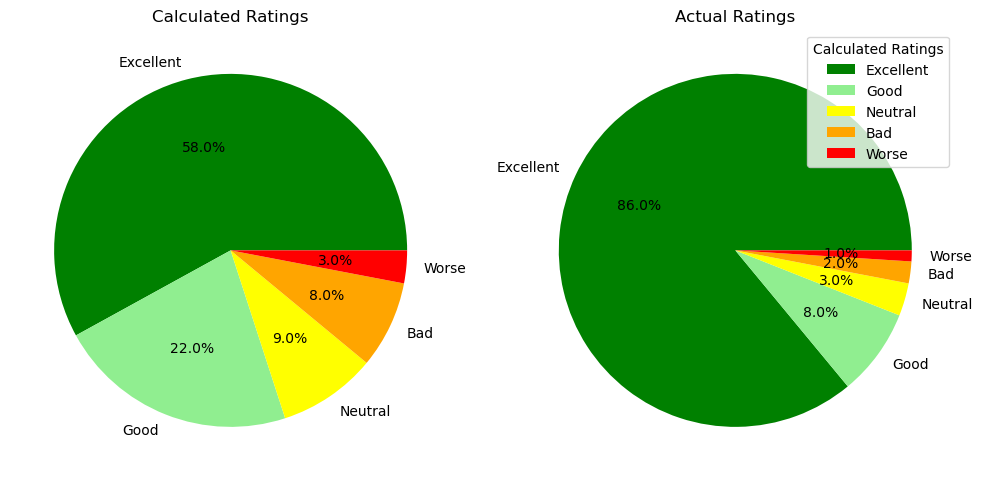

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
X1=df1['sentiment']
X2=df2['overall']
labels=['Excellent','Good','Neutral','Bad','Worse']
colors=['green','lightgreen','yellow','orange','red']
axs[0].pie(X1, labels=labels,colors=colors, autopct='%1.1f%%')
axs[0].set_title('Calculated Ratings')

axs[1].pie(X2, labels=labels,colors=colors, autopct='%1.1f%%')
axs[1].set_title('Actual Ratings')
plt.legend(title="Calculated Ratings")
plt.tight_layout()
plt.show()